## Cat vs Dog Image Classification Using Support Vector Machine

#### Import Required Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import joblib
import gradio as gr

from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)

#### Define Dataset Path

In [2]:
DATASET_PATH = "Dataset/Pet_Images"

#### Load and Preprocess Images

In [3]:
def load_images(dataset_path, size=(64, 64)):
    X, y = [], []
    errors = []
    for label in os.listdir(dataset_path):
        path = os.path.join(dataset_path, label)
        for file in os.listdir(path):
            img_path = os.path.join(path, file)
            img = cv2.imread(img_path)
            if img is None:
                errors.append(img_path)
                continue
            img = cv2.resize(img, size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            X.append(img.flatten())
            y.append(label)
    return np.array(X), np.array(y), errors

X, y, errors = load_images(DATASET_PATH)
print(f"Loaded {len(X)} images with {len(errors)} errors.")

Loaded 4000 images with 0 errors.


#### Check size distribution of all images

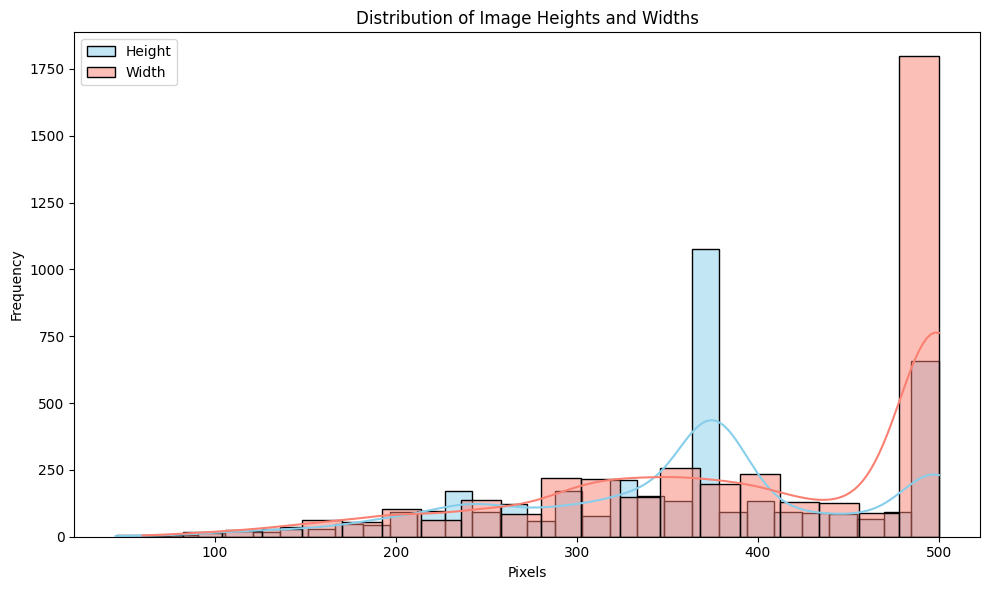

In [4]:
image_shapes = []

for label in os.listdir(DATASET_PATH):
    folder = os.path.join(DATASET_PATH, label)
    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)
        img = cv2.imread(img_path)
        if img is not None:
            h, w = img.shape[:2]
            image_shapes.append((h, w))

image_shapes = np.array(image_shapes)
plt.figure(figsize=(10, 6))
sns.histplot(image_shapes[:, 0], color="skyblue", label="Height", kde=True)
sns.histplot(image_shapes[:, 1], color="salmon", label="Width", kde=True)
plt.legend()
plt.title("Distribution of Image Heights and Widths")
plt.xlabel("Pixels")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

#### Visualize Some Errors

In [5]:
print("Example corrupt images (if any):")
for i in errors[:5]:
    print(i)

Example corrupt images (if any):


#### Visualize sample images per class

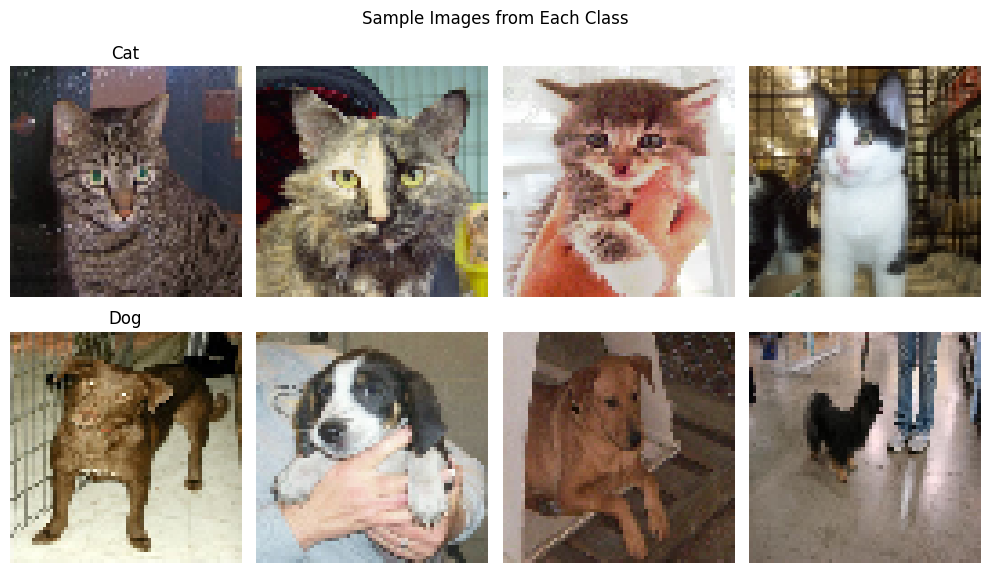

In [6]:
fig, axes = plt.subplots(2, 4, figsize=(10, 6))
class_dirs = os.listdir(DATASET_PATH)
for i, class_name in enumerate(class_dirs):
    class_path = os.path.join(DATASET_PATH, class_name)
    sample_imgs = os.listdir(class_path)[:4]
    for j, img_file in enumerate(sample_imgs):
        img_path = os.path.join(class_path, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(cv2.resize(img, (64, 64)), cv2.COLOR_BGR2RGB)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(class_name)
plt.suptitle("Sample Images from Each Class")
plt.tight_layout()
plt.show()

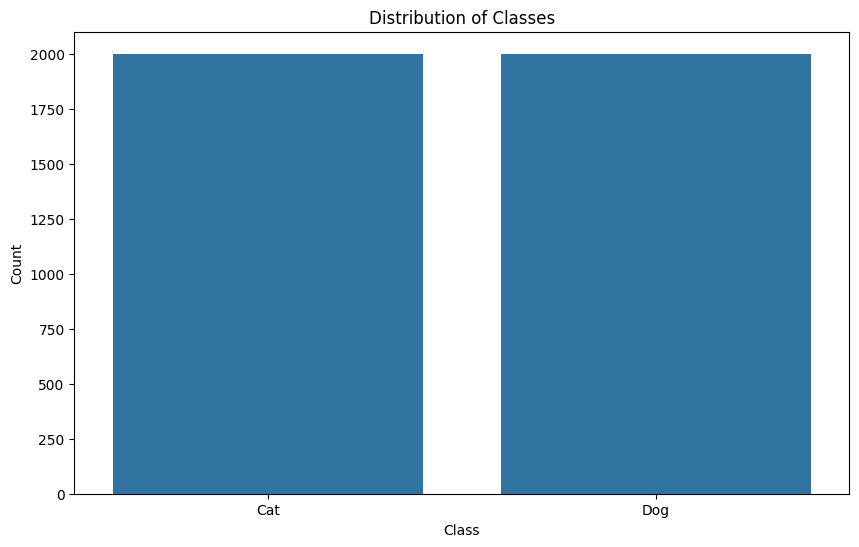

In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(x=y)
plt.title("Distribution of Classes")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

#### Encode Labels

In [8]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("Classes:", le.classes_)

Classes: ['Cat' 'Dog']


#### Scale the Features

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Train-Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

#### PCA for Visualization (2D)

In [11]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

#### Visualize PCA

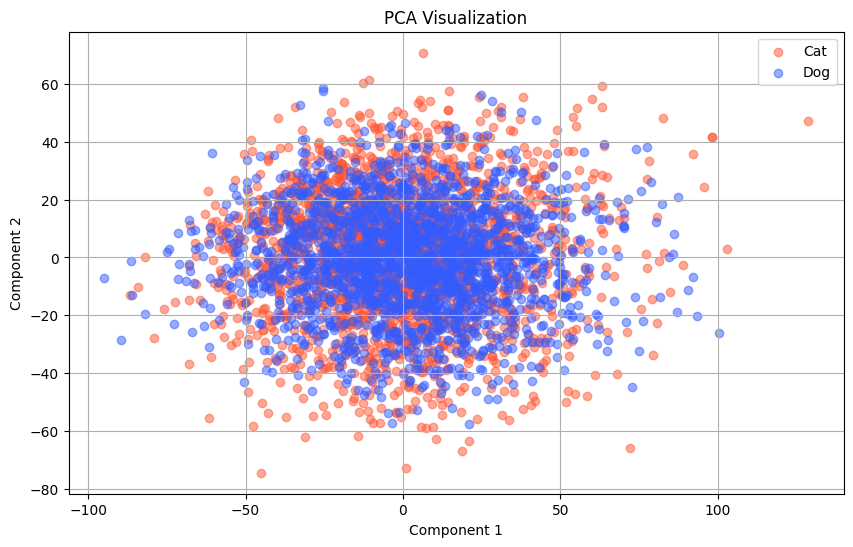

In [12]:
plt.figure(figsize=(10, 6))
colors = ['#FF5733', '#335BFF']
for i, label in enumerate(np.unique(y_encoded)):
    plt.scatter(X_pca[y_encoded == label, 0], X_pca[y_encoded == label, 1],
                label=le.inverse_transform([label])[0], color=colors[i], alpha=0.5)
plt.title("PCA Visualization")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.grid(True)
plt.show()

#### Define SVM Model and Parameters

In [13]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
svc = SVC(probability=True)

#### Train Using GridSearchCV

In [14]:
grid = GridSearchCV(svc, param_grid, cv=3, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)
svm_model = grid.best_estimator_
print("Best Params:", grid.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


#### Evaluate the Model

In [15]:
y_pred = svm_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.6075
              precision    recall  f1-score   support

         Cat       0.62      0.55      0.58       400
         Dog       0.60      0.67      0.63       400

    accuracy                           0.61       800
   macro avg       0.61      0.61      0.61       800
weighted avg       0.61      0.61      0.61       800



#### Confusion Matrix

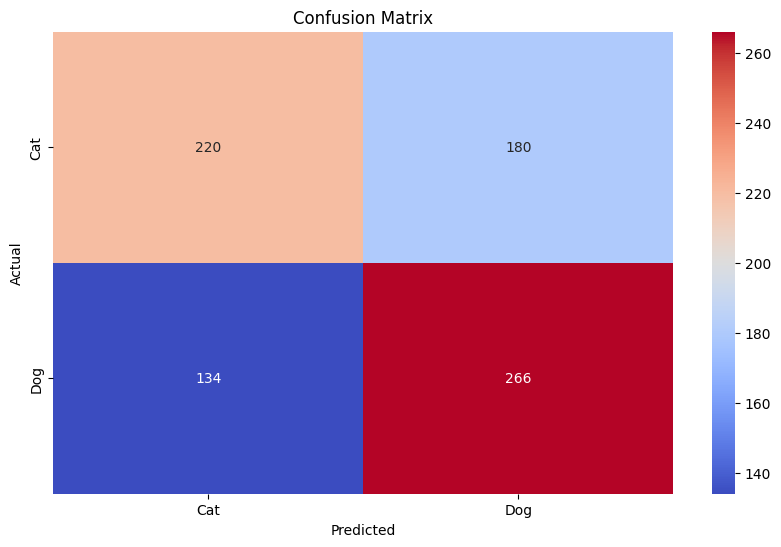

In [16]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='coolwarm')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#### Class Probability Histogram

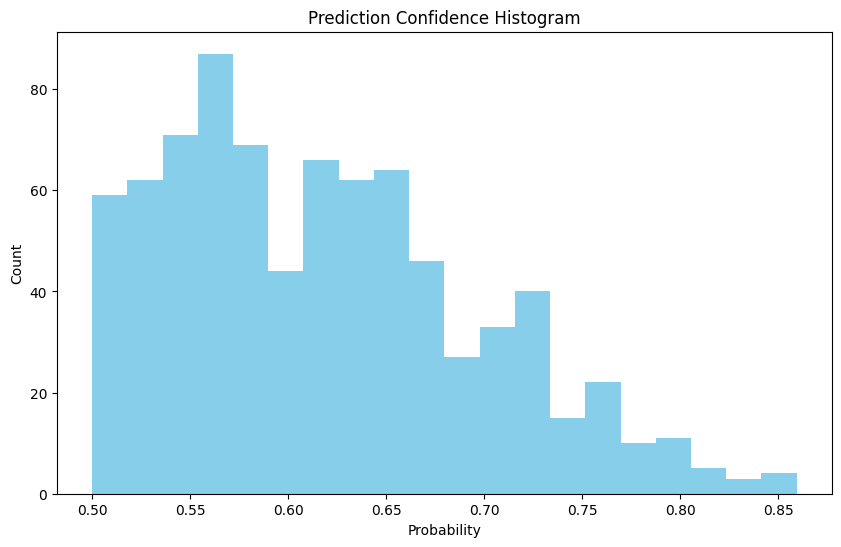

In [17]:
probs = svm_model.predict_proba(X_test)
plt.figure(figsize=(10, 6))
plt.hist(probs.max(axis=1), bins=20, color='skyblue')
plt.title("Prediction Confidence Histogram")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.show()

#### t-SNE 2D Projection of Features

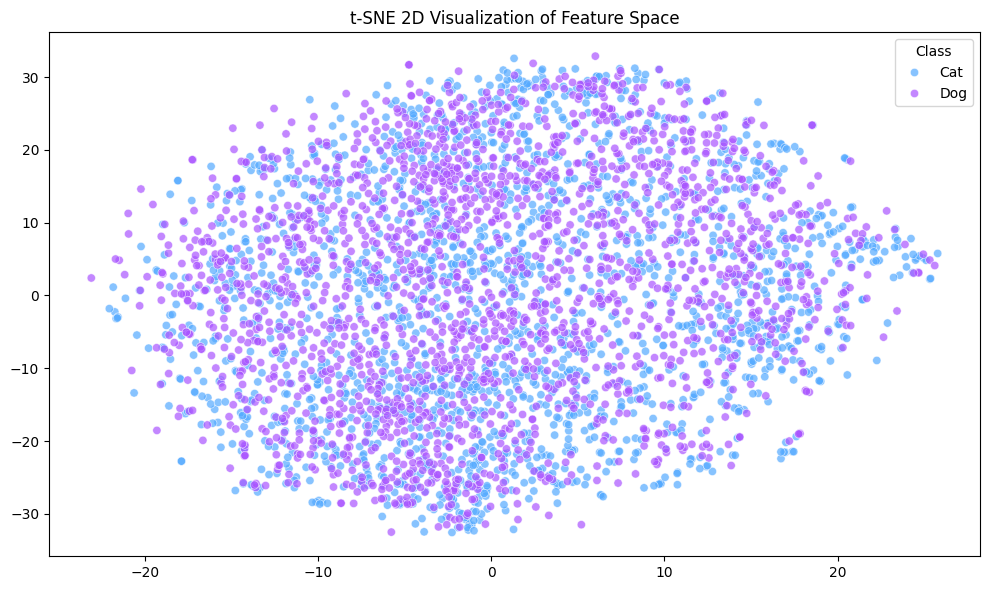

In [18]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=le.inverse_transform(y_encoded), palette='cool', alpha=0.7)
plt.title("t-SNE 2D Visualization of Feature Space")
plt.legend(title="Class")
plt.tight_layout()
plt.show()

#### Save Model and Scaler

In [19]:
joblib.dump(svm_model, "Models/SVM_Cat_Dog_model.pkl")
joblib.dump(scaler, "Models/Scaler.pkl")
joblib.dump(le, "Models/Label_Encoder.pkl")

['Models/Label_Encoder.pkl']

#### Load Saved Model

In [20]:
svm_model = joblib.load("Models/SVM_Cat_Dog_model.pkl")
scaler = joblib.load("Models/Scaler.pkl")
le = joblib.load("Models/Label_Encoder.pkl")

#### Predict New Image

In [21]:
def predict_image(image_path, model, scaler, le, size=(64, 64)):
    img = cv2.imread(image_path)
    img = cv2.resize(img, size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_flat = img.flatten().reshape(1, -1)
    img_scaled = scaler.transform(img_flat)
    pred = model.predict(img_scaled)
    label = le.inverse_transform(pred)[0]
    plt.imshow(img, cmap='gray')
    plt.title(f"Prediction: {label}")
    plt.axis('off')
    plt.show()

#### Distribution of SVM prediction probabilities

C:\Users\Acer\AppData\Local\Temp\ipykernel_9388\3938084744.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(probabilities, shade=True, color='green')


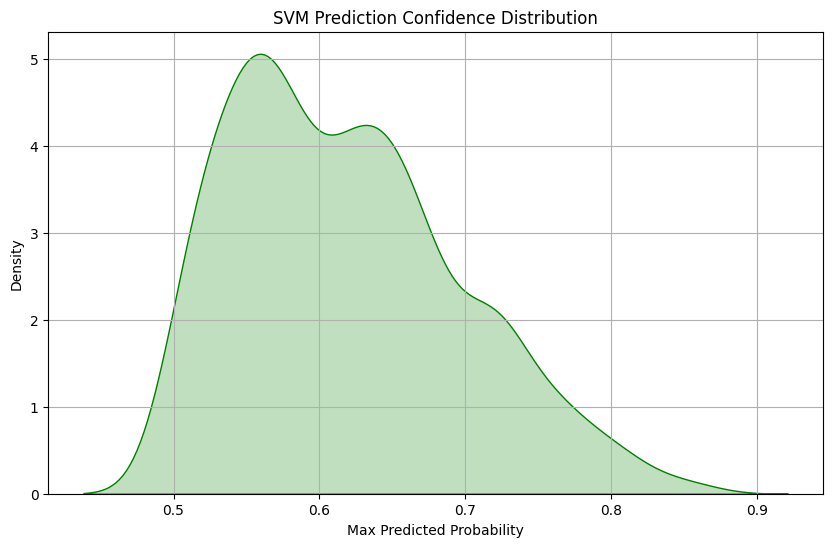

In [22]:
probabilities = svm_model.predict_proba(X_test).max(axis=1)
plt.figure(figsize=(10, 6))
sns.kdeplot(probabilities, shade=True, color='green')
plt.title("SVM Prediction Confidence Distribution")
plt.xlabel("Max Predicted Probability")
plt.ylabel("Density")
plt.grid(True)
plt.show()

#### Run Prediction Example

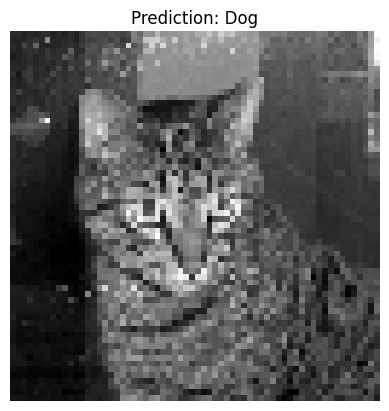

In [23]:
predict_image("Dataset/Pet_Images/Cat/1.jpg", svm_model, scaler, le)

#### ROC Curve

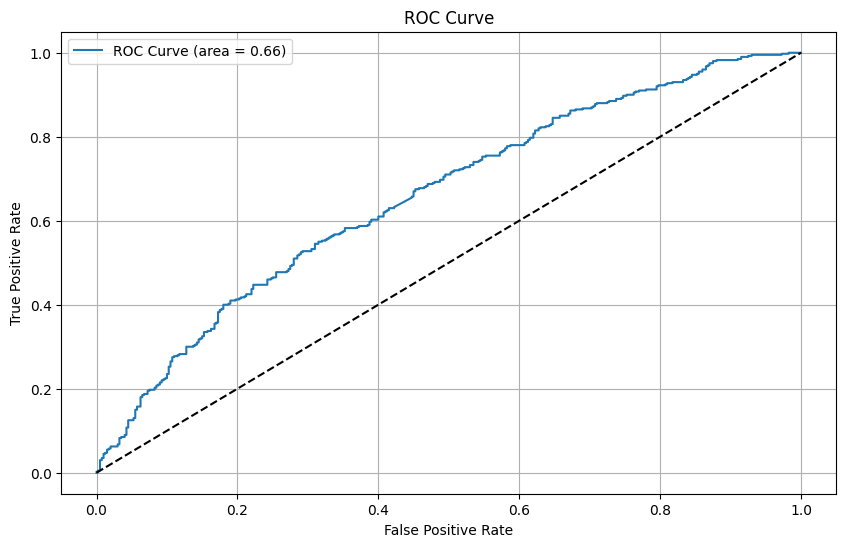

In [24]:
fpr, tpr, _ = roc_curve(y_test, probs[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

#### Show Misclassified Images

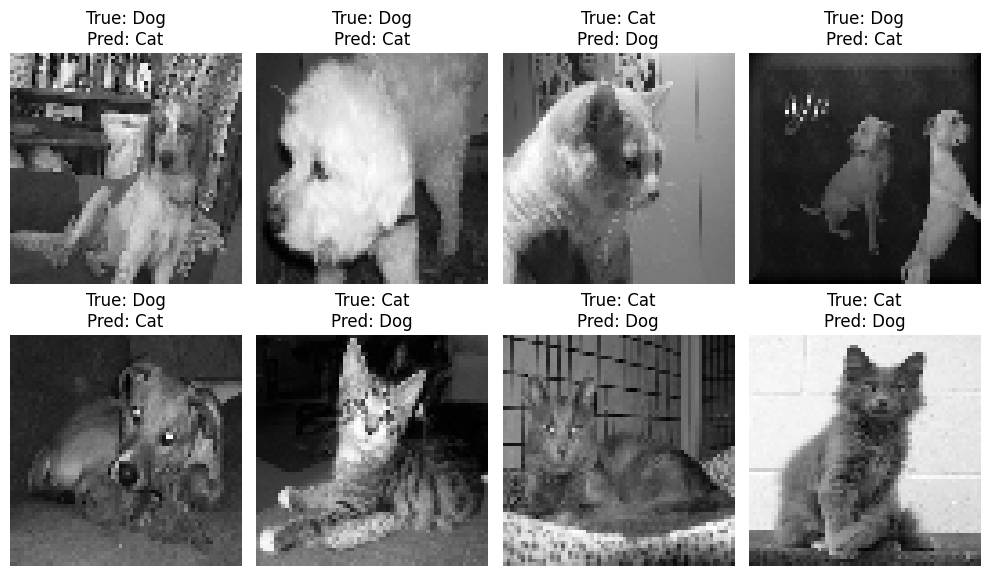

In [25]:
def show_misclassified(X_test_raw, y_true, y_pred, le, max_images=8):
    misclassified = np.where(y_true != y_pred)[0]
    if len(misclassified) == 0:
        print("No misclassifications.")
        return
    plt.figure(figsize=(10, 6))
    for i, idx in enumerate(misclassified[:max_images]):
        img = X_test_raw[idx].reshape(64, 64)
        true_label = le.inverse_transform([y_true[idx]])[0]
        pred_label = le.inverse_transform([y_pred[idx]])[0]
        plt.subplot(2, 4, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Reconstruct original X_test for visualization
X_test_raw = scaler.inverse_transform(X_test)
show_misclassified(X_test_raw, y_test, y_pred, le)

#### Confidence comparison for correct vs incorrect predictions

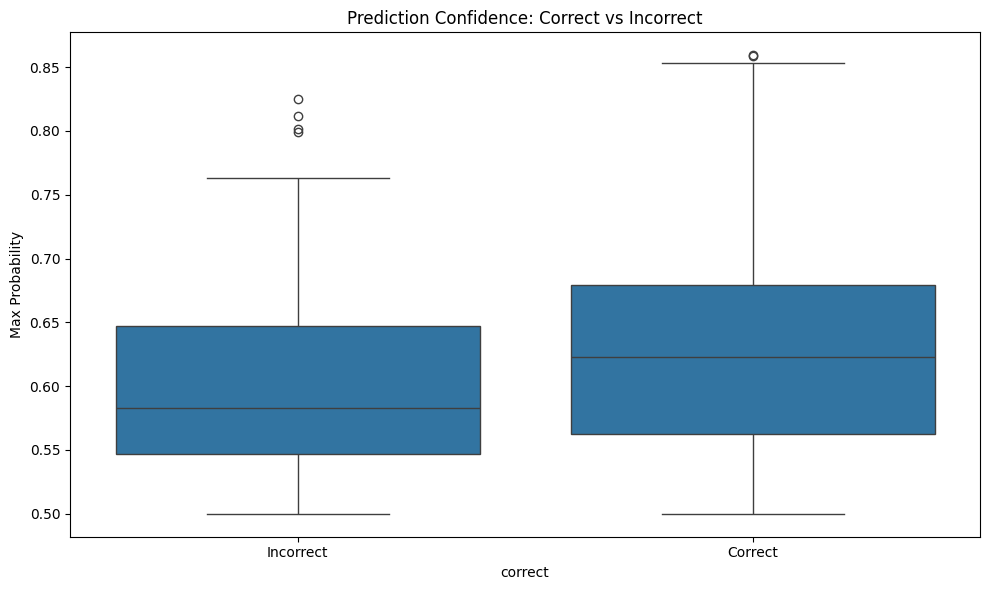

In [26]:
probs = svm_model.predict_proba(X_test).max(axis=1)
correct = y_test == y_pred
df_conf = pd.DataFrame({'confidence': probs, 'correct': correct})

plt.figure(figsize=(10, 6))
sns.boxplot(x='correct', y='confidence', data=df_conf)
plt.xticks([0, 1], ['Incorrect', 'Correct'])
plt.title("Prediction Confidence: Correct vs Incorrect")
plt.ylabel("Max Probability")
plt.tight_layout()
plt.show()

#### Check Model File Size

In [27]:
model_size = os.path.getsize("Models/SVM_Cat_Dog_model.pkl") / 1024
print(f"SVM Model File Size: {model_size:.2f} KB")

SVM Model File Size: 94843.48 KB


#### Pie Chart of Class Distribution

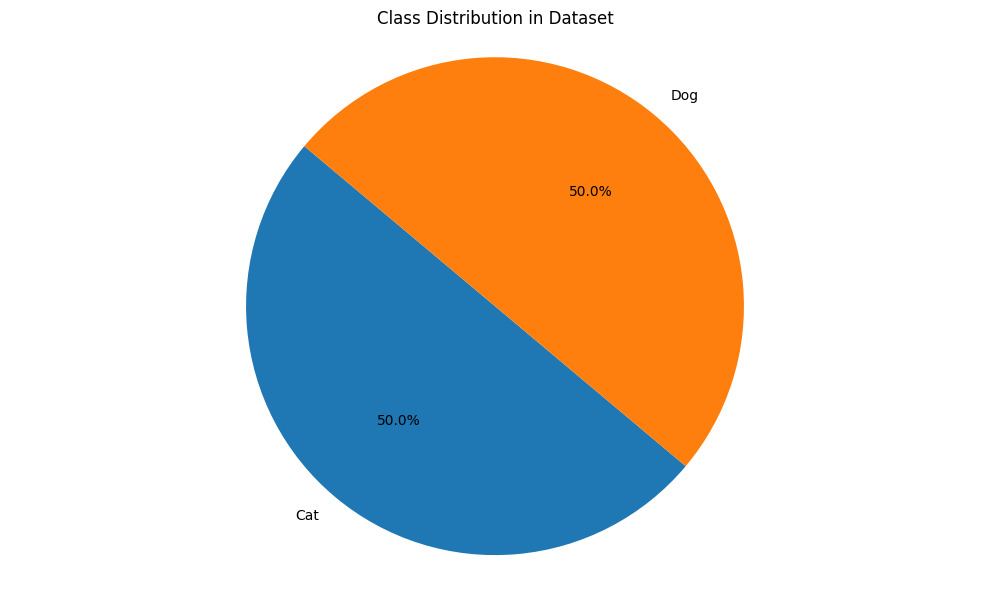

In [28]:
unique, counts = np.unique(y_encoded, return_counts=True)
labels = le.inverse_transform(unique)

plt.figure(figsize=(10, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Class Distribution in Dataset")
plt.axis('equal')
plt.tight_layout()
plt.show()

#### Explained Variance by PCA

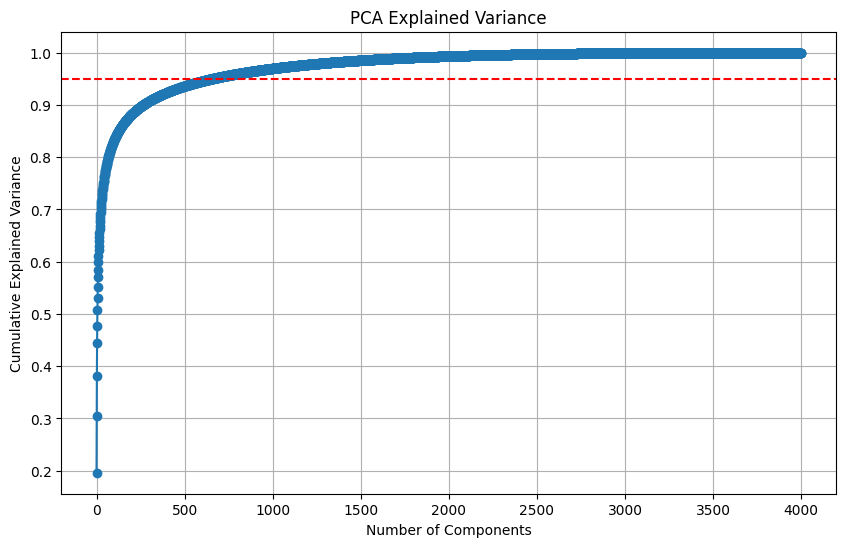

In [29]:
pca_100 = PCA().fit(X_scaled)
explained = np.cumsum(pca_100.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.plot(explained, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.grid(True)
plt.axhline(0.95, color='r', linestyle='--')
plt.show()

#### Compare with KNN Classifier

In [30]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
print("KNN Accuracy:", accuracy_score(y_test, knn_pred))

KNN Accuracy: 0.525


#### Compare SVM vs KNN Bar Plot

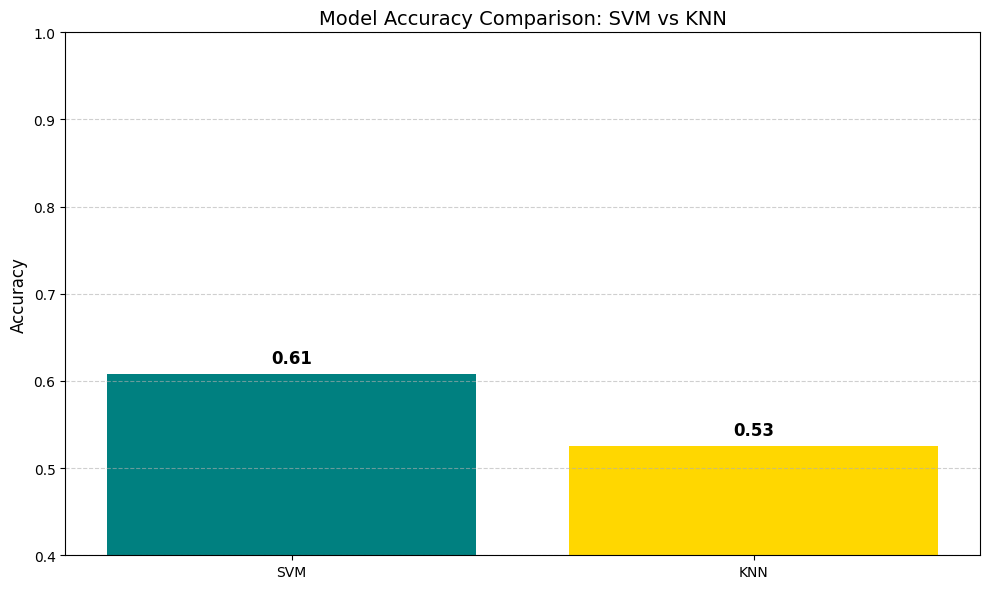

In [31]:
svm_acc = accuracy_score(y_test, y_pred)
knn_acc = accuracy_score(y_test, knn_pred)

plt.figure(figsize=(10, 6))
bars = plt.bar(["SVM", "KNN"], [svm_acc, knn_acc], color=['#008080', '#FFD700'])

for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5),  # vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title("Model Accuracy Comparison: SVM vs KNN", fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0.4, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#### Class-wise Accuracy

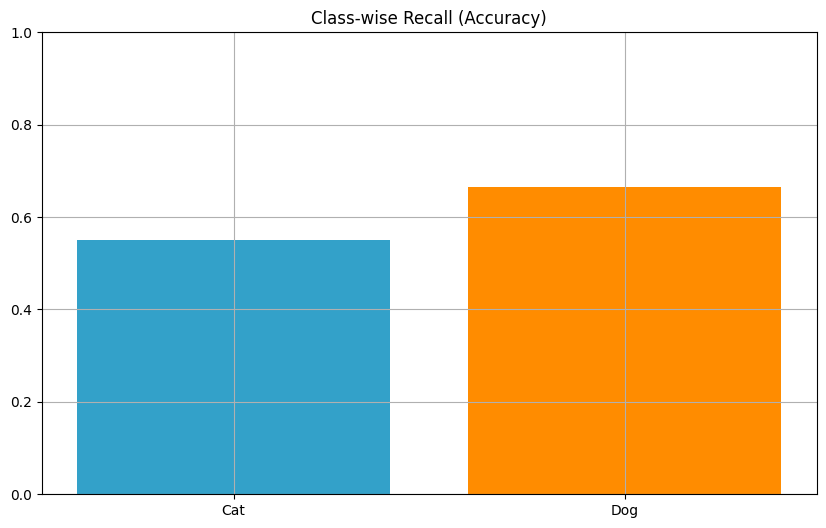

In [32]:
report_dict = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
plt.figure(figsize=(10, 6))
class_accuracies = [report_dict[c]["recall"] for c in le.classes_]

plt.bar(le.classes_, class_accuracies, color=['#33A1C9', '#FF8C00'])
plt.title("Class-wise Recall (Accuracy)")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

#### Save PCA for Reuse

In [33]:
joblib.dump(pca, "Models/PCA.pkl")

['Models/PCA.pkl']

#### Predict Image with PCA + SVM

In [34]:
def predict_image_with_pca(img_path, model, scaler, le, pca, size=(64, 64)):
    img = cv2.imread(img_path)
    img = cv2.resize(img, size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_flat = img.flatten().reshape(1, -1)
    img_scaled = scaler.transform(img_flat)
    img_pca = pca.transform(img_scaled)
    pred = model.predict(img_scaled)[0]
    prob = model.predict_proba(img_scaled)[0].max()
    label = le.inverse_transform([pred])[0]

    plt.imshow(img, cmap='gray')
    plt.title(f"Prediction: {label} ({prob:.2f})")
    plt.axis('off')
    plt.show()

#### Run PCA+Prediction

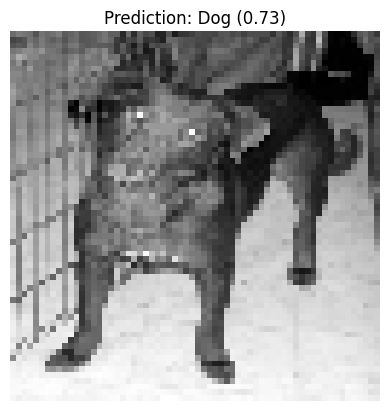

In [35]:
predict_image_with_pca("Dataset/Pet_Images/Dog/1.jpg", svm_model, scaler, le, pca)

#### Save Accuracy Log

In [36]:
with open("Logs/Accuracy_Log.txt", "w") as f:
    f.write(f"SVM Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
    f.write(f"KNN Accuracy: {accuracy_score(y_test, knn_pred):.4f}\n")

#### Export Class Report to CSV

In [37]:
df_report = pd.DataFrame(report_dict).transpose()
df_report.to_csv("Logs/Classification_Report.csv")

#### List Files in Dataset

In [38]:
def count_images_in_dirs(path):
    count = Counter()
    for label in os.listdir(path):
        count[label] = len(os.listdir(os.path.join(path, label)))
    return count

count_result = count_images_in_dirs(DATASET_PATH)
print(count_result)

Counter({'Cat': 2000, 'Dog': 2000})


#### Heatmap of Scaled Data Sample

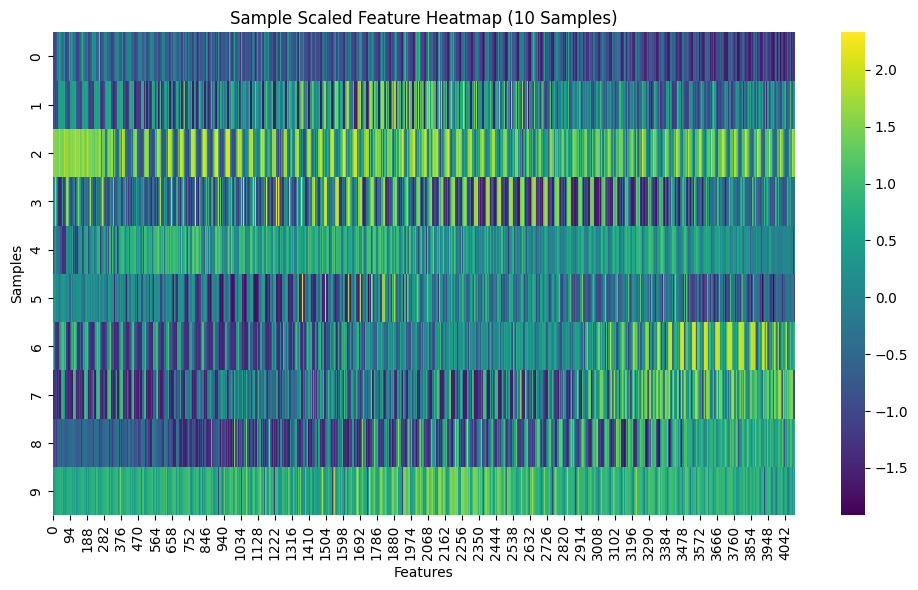

In [39]:
plt.figure(figsize=(10, 6))
sns.heatmap(X_scaled[:10], cmap='viridis', cbar=True)
plt.title("Sample Scaled Feature Heatmap (10 Samples)")
plt.xlabel("Features")
plt.ylabel("Samples")
plt.tight_layout()
plt.show()

#### Load Saved Model

In [40]:
svm_model = joblib.load("Models/SVM_Cat_Dog_model.pkl")
scaler = joblib.load("Models/Scaler.pkl")
le = joblib.load("Models/Label_encoder.pkl")

#### Gradio Interface for Image Prediction

In [41]:
def predict_cat_dog(img):
    img_resized = cv2.resize(img, (64, 64))
    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
    img_flat = img_gray.flatten().reshape(1, -1)
    img_scaled = scaler.transform(img_flat)
    probs = svm_model.predict_proba(img_scaled)[0]
    pred_class = svm_model.predict(img_scaled)[0]
    class_name = le.inverse_transform([pred_class])[0]
    confidence = np.max(probs)
    return f"Prediction: {class_name} (Confidence: {confidence:.2f})"

#### Launch Gradio interface

In [42]:
interface = gr.Interface(
    fn=predict_cat_dog,
    inputs=gr.Image(type="numpy", label="Upload an Image"),
    outputs=gr.Textbox(label="Prediction"),
    title="Cat vs Dog Image Classifier",
    description="Upload a 64x64 image of a cat or dog to get a prediction."
)

interface.launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.
